In [ ]:
%%capture
!pip install catalyst

In [ ]:
import torch
import torchvision

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision

import catalyst
from catalyst.dl import Runner

import numpy as np

In [ ]:
from types import SimpleNamespace

args = SimpleNamespace(**{
    'no_cuda': False,
    'rand_seed': 10,
    'batch_size': 20
})

use_cuda = torch.cuda.is_available() and not args.no_cuda
device = torch.device('cuda' if use_cuda else 'cpu')

torch.manual_seed(args.rand_seed)
if use_cuda:
  torch.cuda.manual_seed(args.rand_seed)
np.random.seed(args.rand_seed)

# Dirichlet Prior Network

In [ ]:
# Uncertainty measures

# Total uncertainty
def max_prob(probs):
  # Minus is for uncertainty here
  return -torch.max(probs, axis=1).values

def entropy(probs):
  logs = torch.log2(probs)
  logs[torch.isinf(logs)] = 0
  return -(probs * logs).sum(axis = 1)

# Data uncertainty 
def exp_of_entr(alphas, precision=None):
  """
  Expected entropy of ensemble predictions.
  You can pass precalculated values.
  """
  if precision is None:
    precision = alphas.sum(axis = 1)
   
  return - torch.sum(alphas * (1/precision)[:, None] * 
                                (torch.digamma(alphas+1) - torch.digamma(precision + 1)[:, None]), axis=1)

# Distirbutional uncertainty
def mutual_info(alphas, precision=None, probs=None):
  """
  Mutual information between predicted label and mu - shows the spread of the ensamble.
  You can pass precalculated values.
  """  
  if precision is None:
    precision = alphas.sum(axis = 1)
  if probs is None:
    probs = alphas * (1 / alphas.sum(axis = 1))[:, None]

  entropy_of_expected = entropy(probs)
  expected_of_entropy = exp_of_entr(alphas, precision)

  return entropy_of_expected - expected_of_entropy

def diff_entropy(alphas, precision=None):
  """
  Differential entropy of resulting dirichlet distribution.
  You can pass precalculated values.
  """
  if precision is None:
    precision = alphas.sum(axis = 1)

  lgamma_term = torch.lgamma(alphas)
  digamma_term = (alphas - 1) * (torch.digamma(alphas) - torch.digamma(precision)[:, None])

  return torch.sum(lgamma_term - digamma_term, axis=1) - torch.lgamma(precision)

# Calculate all
def get_dpn_measures(alphas, probs=None):
  
  precision = alphas.sum(axis = 1)
  if probs is None:
    probs = alphas * (1 / alphas.sum(axis = 1))[:, None]

  metrics = [
      ("max_prob", max_prob(probs)),
      ("entropy", entropy(probs)),
      ("exp_of_entropy", exp_of_entr(alphas, precision)),
      ("mutual_info", mutual_info(alphas, precision, probs)),
      ("diff_entropy", diff_entropy(alphas, precision))
  ]

  return [[x[0], x[1].detach().to('cpu').numpy()] for x in metrics]

In [ ]:
#####

# Uncertainty measures visualization for debug

#####

# code for dirichlet distribution visualization came from here - http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

def vis_metrics(alphas):
  draw_pdf_contours(Dirichlet(alphas))
  mes = get_dpn_measures(torch.Tensor([alphas]))
  for x in mes:
    print(x)

Highly confident prediction
['max_prob', array([-0.9090909], dtype=float32)]
['entropy', array([0.5304061], dtype=float32)]
['exp_of_entropy', array([0.3588612], dtype=float32)]
['mutual_info', array([0.17154491], dtype=float32)]
['diff_entropy', array([-5.13266], dtype=float32)]


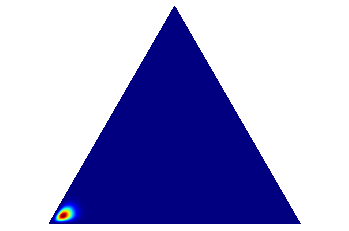

In [ ]:
print("Highly confident prediction")
vis_metrics([100, 5, 5])

Less confident prediction
['max_prob', array([-0.7692308], dtype=float32)]
['entropy', array([0.99126434], dtype=float32)]
['exp_of_entropy', array([0.67949766], dtype=float32)]
['mutual_info', array([0.31176668], dtype=float32)]
['diff_entropy', array([-4.4233093], dtype=float32)]


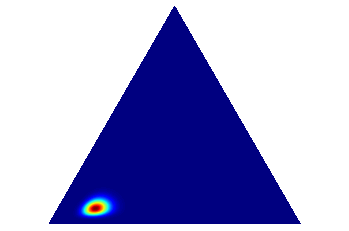

In [ ]:
print("Less confident prediction")
vis_metrics([100, 20, 10])

High data uncertainty
['max_prob', array([-0.33333334], dtype=float32)]
['entropy', array([1.5849626], dtype=float32)]
['exp_of_entropy', array([1.0660186], dtype=float32)]
['mutual_info', array([0.518944], dtype=float32)]
['diff_entropy', array([-2.2690506], dtype=float32)]


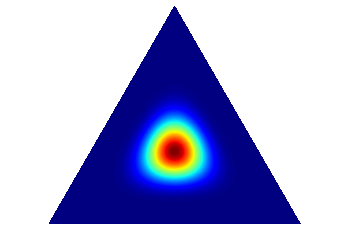

In [ ]:
print("High data uncertainty")
vis_metrics([10, 10, 10])

High distributional uncertainty
['max_prob', array([-0.33333334], dtype=float32)]
['entropy', array([1.5849626], dtype=float32)]
['exp_of_entropy', array([0.25456434], dtype=float32)]
['mutual_info', array([1.3303983], dtype=float32)]
['diff_entropy', array([-13.024984], dtype=float32)]


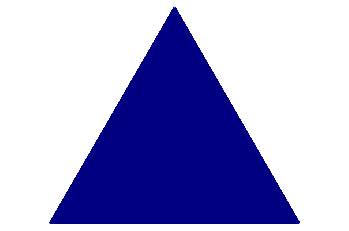

In [ ]:
print("High distributional uncertainty")
vis_metrics([0.1, 0.1, 0.1])

In [ ]:
# Class with uncertainty measures

class DPNClass(nn.Module):
  
  def __init__(self, model):
    super(DPNClass, self).__init__()
    self.model = model
  
  def forward(self, x):
    """
    Get alphas for target dirichlet distribution.
    """
    return torch.exp(self.model.forward(x))
  
  def get_expected(self, x):
    """
    Get an expected probability vector.
    """
    alphas = self.forward(x)
    return alphas * (1 / alphas.sum(axis = 1))[:, None]

In [ ]:
# Loss function

## KL divergence

def dirichlet_kl_divergence(alphas, target_alphas, epsilon=1e-8):
  """
  Calculate kl divergence between two dirichlet distributions.
  epsilon: smoothing parameter for targets
  """

  precision = alphas.sum(axis = 1) + epsilon * alphas.shape[1]
  target_precision = target_alphas.sum(axis = 1) + epsilon * target_alphas.shape[1]

  precision_term = torch.lgamma(target_precision) - torch.lgamma(precision)

  alphas_term = torch.sum( torch.lgamma(alphas + epsilon) - torch.lgamma(target_alphas + epsilon) + 
   (target_alphas - alphas) * (torch.digamma(target_alphas + epsilon) - torch.digamma(target_precision)[:, None] ), axis = 1)
  
  cost = precision_term + alphas_term

  return cost

def dirichlet_reverse_kl_divergence(alphas, target_alphas, epsilon=1e-8):
  """
  Reverse kl divergence. Used as a distance metric in follow up paper. 
  """
  return dirichlet_kl_divergence(alphas=target_alphas, target_alphas=alphas, epsilon=epsilon)

In [ ]:
class DirichletKLLoss(nn.Module):

  def __init__(self, target_concentration=1e2, base_concentration=1.0, reverse=True, gamma=1.0):
    super(DirichletKLLoss,self).__init__()
    self.target_concentration = target_concentration
    self.base_concentration = base_concentration
    self.reverse = reverse
    self.gamma = gamma

  def forward(self, alphas, labels=None):
    costs = self.dirichlet_kl_loss(alphas, labels, self.target_concentration, self.base_concentration, self.reverse)
    return torch.sum(costs)
  
  @staticmethod 
  def dirichlet_kl_loss(alphas, labels=None, target_concentration=1e2, base_concentration=1.0, reverse=True):
    """
    alphas: batch_size * num_classes.
    labels: batch_size. If None - ood data is supposed.
    reverse: Should reverse kl divergence be used. 
    """

    # Make target distribution
    target_alphas = torch.ones_like(alphas) * base_concentration

    if labels is not None:
      target_alphas += torch.zeros_like(target_alphas).scatter_(1, labels[:,None], value=1) * target_concentration

    cost = 0
    if reverse:
      cost = dirichlet_reverse_kl_divergence(alphas, target_alphas)
    else:
      cost = dirichlet_kl_divergence(alphas, target_alphas)
    
    return cost

In [ ]:
# To iterate domain and ood data on one batch
class PriorNetDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, main_dataset, ood_dataset):
      self.main_dataset = main_dataset
      self.ood_dataset = ood_dataset
      self.length = len(main_dataset)

      # If ood data is bigger we would still want to iterate over all of it. 
      # so lets say that one element of main is responsible for slice_len elements of ood data. 
      self.slice_len = int(np.ceil(len(ood_dataset)/len(main_dataset)))
      self.j = 0

    def __getitem__(self, i: int):
      dom_el = self.main_dataset[i]
      ood_el = self.ood_dataset[(i*self.slice_len + self.j) % len(self.ood_dataset)]
      self.j = (self.j + 1) % self.slice_len
      return (dom_el, ood_el[0])

    def __len__(self):
      return self.length

In [ ]:
# Special catalyst runner
class PriorNetRunner(Runner):

  def _handle_batch(self, batch):

    dom_data, ood_data = batch
    print(dom_data)
    if dom_data.isnan().max() or ood_data.isnan().max(): 
      print('Input is nan')

    dom_pred =    self.model(dom_data[0])
    dom_probs = dom_pred * (1 / dom_pred.sum(axis = 1))[:, None]
    ood_pred =    self.model(ood_data)

    if dom_pred.isnan().max():
      print(dom_pred)
      raise Exception("Got nan predictions on dom.")
    if ood_pred.isnan().max():
      print(ood_pred)
      raise Exception("Got nan predictions on ood.")

    # Calculate loss and main metric
    dom_loss = self.criterion(dom_pred, dom_data[1])
    ood_loss = self.criterion(ood_pred)

    loss = dom_loss + ood_loss * self.criterion.gamma
    acc = metrics.accuracy(dom_probs, dom_data[1])[0] # since dpn outputs exponents

    # Calculate MI on domain and ood data
    dom_mi = torch.mean(mutual_info(dom_pred))
    ood_mi = torch.mean(mutual_info(ood_pred))

    self.batch_metrics.update({"loss": loss, "acc": acc, "dom_mi": dom_mi, "ood_mi": ood_mi})
  
  def predict_batch(self, batch):

    dom_data, ood_data = batch
    dom_pred =    self.model(dom_data[0].to(self.device))
    ood_pred =    self.model(ood_data.to(self.device))

    return (dom_pred, ood_pred)

# Experiments


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import catalyst
from catalyst.dl import SupervisedRunner
from torch.utils.data import DataLoader, TensorDataset
from dataclasses import dataclass
import copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Synthetic data

In [ ]:
# Generate mixture of gaussians

def gen_three_gaussians(a, std, num_points):
  """
  a: distance between gaussian centers
  num_points: points for each class
  """
  centers = np.array([
    [0,np.sqrt(3)/3 * a], [-a/2, -np.sqrt(3)/6 * a], [a/2, -np.sqrt(3)/6 * a]
  ])

  data_X, data_Y = [], []

  for i, c in enumerate(centers):
    data_X.extend(np.random.multivariate_normal(c, std * np.identity(c.shape[0]), num_points))
    data_Y.extend([i for _ in range(num_points)])
  
  return np.array(data_X), np.array(data_Y)


def gen_ood(center, radius, width, num_points):

  angles = np.random.uniform(0,1,num_points) * 2 * np.pi
  radiuses = radius + width * np.random.uniform(0,1,num_points)

  return np.column_stack( [center[0] + radiuses * np.cos(angles), center[1] + radiuses * np.sin(angles)] )

In [ ]:
class ToyModel(nn.Module):
  def __init__(self):
    super(ToyModel, self).__init__()
    self.fc1 = nn.Linear(2, 50)
    self.out = nn.Linear(50, 3)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    return self.out(x)

In [ ]:
def viz_metrics(model, metrics_fun, lim, train_X=None, ood_X=None, show_data=False):
  """
  metrics_fun: function that returns list of tuples (function name, value)
  """

  xs, ys = torch.linspace(-lim, lim), torch.linspace(-lim, lim)
  points = torch.stack(torch.meshgrid([xs, ys]), dim=-1).view([-1, 2]).to('cpu')
  
  preds = model(points)

  metric_vals = metrics_fun(preds)

  fig, axs = plt.subplots(1, len(metric_vals), figsize=(15,5))

  for i, (n, vals) in enumerate(metric_vals):

    # Plots
    
    c = axs[i].pcolormesh(xs.numpy(), ys.numpy(), vals.reshape([100,100]), cmap='RdBu')
    axs[i].set_title(n)
    axs[i].set(adjustable='box', aspect='equal')
    
    if show_data:
      axs[i].scatter(train_X[:,0].numpy(), train_X[:,1].numpy(), c='white', alpha=0.01)
      axs[i].scatter(ood_X[:,0].numpy(), ood_X[:,1].numpy(), c='blue', alpha=0.01)

    fig.colorbar(c, ax=axs[i])

  plt.show()

In [ ]:
class SilentLogg(catalyst.core.callbacks.logging.ConsoleLogger):
  def __init__(self):
    super(SilentLogg, self).__init__()
  def on_epoch_end(self, runner: catalyst.core.runner.IRunner):
    pass

In [ ]:
@dataclass
class SyntheticConfig:
  model: nn.Module
  name: str = "Experiment on synthetic data."
  center_dist: float = 10
  std: float = 4
  ood_border: float = 15
  data_num: int = 500
  ood_num: int = 600
  reverse: bool = True
  num_epochs: int = 60


def run_synthetic_experiment(config: SyntheticConfig, device):
  
  print("Running ", config.name)

  # Generate data
  train_Toy_X, train_Toy_Y = gen_three_gaussians(
                                 config.center_dist, 
                                 config.std,
                                 config.data_num,
                                 )
  ood_Toy_X = gen_ood( 
      [0,0], 
      config.ood_border, 
      config.center_dist/4, 
      config.ood_num)
  
  train_X = torch.Tensor(train_Toy_X).to(device); train_Y = torch.Tensor(train_Toy_Y).type(torch.int64).to(device)
  ood_X = torch.Tensor(ood_Toy_X).to(device)

  # Training

  model_copy = copy.deepcopy(config.model)
  model_copy.model = model_copy.model.to(device) 

  runner = PriorNetRunner()
  criterion = DirichletKLLoss(reverse=config.reverse)
  optimizer = torch.optim.Adam(model_copy.parameters()) 
  prior_dataset = PriorNetDatasetWrapper(TensorDataset(train_X, train_Y), TensorDataset(ood_X))
  
  runner.train(
    model=model_copy, criterion=criterion, optimizer=optimizer, 
    loaders={'train':DataLoader(prior_dataset, batch_size=20, shuffle=True)}, 
    num_epochs=config.num_epochs,
    callbacks={
        "optimizer": catalyst.dl.OptimizerCallback(
        metric_key="loss", 
        accumulation_steps=1,
        grad_clip_params=None,
        ),
        "logger": SilentLogg()
    },
    verbose=False,
  )

  # Evaluation
  # Catalyst sends model to gpu for some reason - may be a library issue.
  model_copy.model = model_copy.model.to(device) 

  viz_metrics(model_copy, get_dpn_measures, 20, train_X, ood_X, show_data=True)

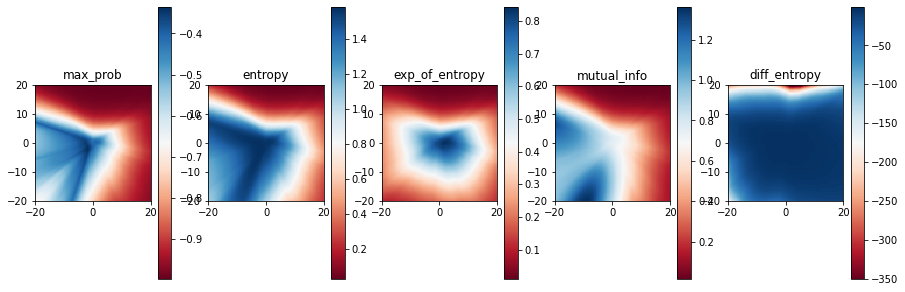

In [ ]:
dpn = DPNClass(ToyModel().to('cpu'))
viz_metrics(dpn, get_dpn_measures, 20)

Running  Standart experiment


/usr/local/lib/python3.6/dist-packages/catalyst/dl/experiment/experiment.py:190: UserWarning:

Attention, there is only one dataloader - train



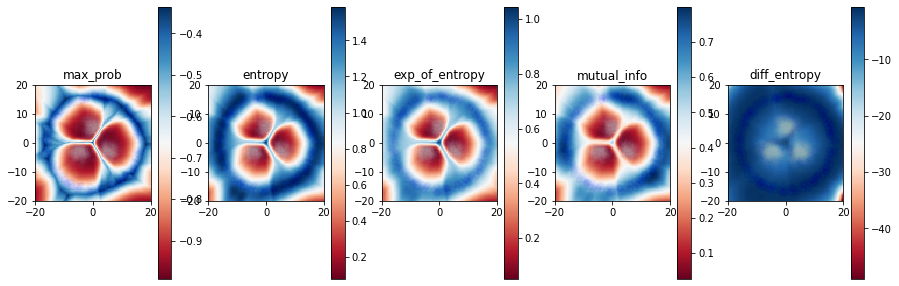

Running  Forward loss experiment


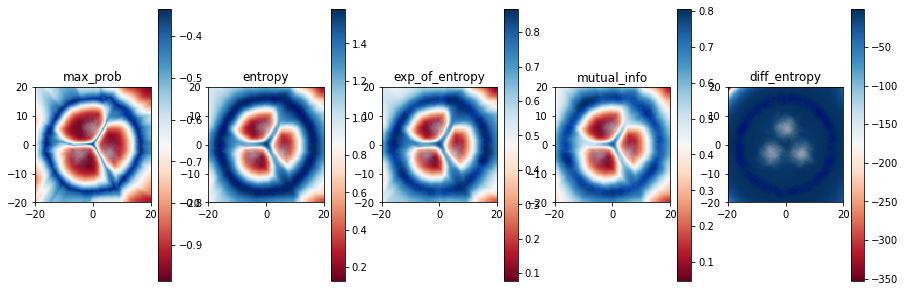

Running  High noise experiment


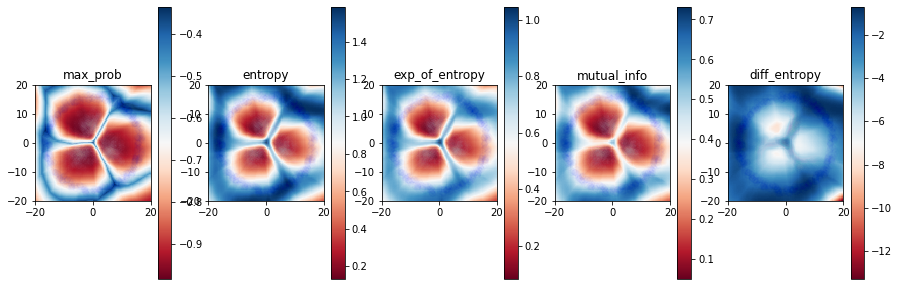

Running  High noise, forward loss experiment


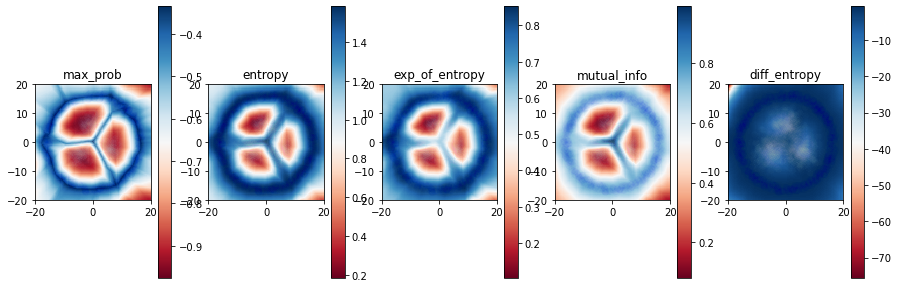

In [ ]:
experiments = [
  SyntheticConfig(dpn, "Standart experiment"),
  SyntheticConfig(dpn, "Forward loss experiment", reverse=False),
  SyntheticConfig(dpn, "High noise experiment", std=7),
  SyntheticConfig(dpn, "High noise, forward loss experiment", std=7, reverse=False),
]

for conf in experiments:
  run_synthetic_experiment(conf, 'cpu')

### Paper experiment recreation

In [ ]:
import os
from torch.utils.data.dataloader import default_collate
from torch.multiprocessing import set_start_method
from catalyst.utils import metrics
from sklearn.metrics import roc_auc_score
from typing import List

data_path = 'data'

#### Loading and transforming data

Black and white stuff

In [ ]:
%%capture
mnist_transf = transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),
                              ])
mnist_path = os.path.join(data_path, 'mnist')

MNIST = (
    datasets.MNIST(mnist_path, train=True, download=True,
                            transform=mnist_transf), 
    datasets.MNIST(mnist_path, train=False, download=True, transform=mnist_transf)
) 

In [ ]:
bw_train = [
  transforms.RandomAffine(0, translate=[0.1, 0.1]),
  transforms.RandomRotation(15, expand=True),
]

In [ ]:
%%capture
omniglot_transforms = [
  transforms.Resize([28, 28], interpolation=2),
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))         
]

omn_path = os.path.join(data_path, 'omng')

omn_train = datasets.Omniglot(omn_path, background=True, transform=transforms.Compose(bw_train+omniglot_transforms), download=True)
omn_test  = datasets.Omniglot(omn_path, background=False, download=True, transform=transforms.Compose(omniglot_transforms))

In [ ]:
class OmniglotDataset(torch.utils.data.Dataset):
  def __init__(self, omn_train, omn_test, train=True, take_from_test=10000):
    
    self.train = train

    if train:
      self.main = omn_train
      self.add = omn_test
      self.base = 0
      self.length = len(omn_train) + take_from_test
    else:
      self.main = omn_test
      self.base = take_from_test
      self.length = len(omn_test) - take_from_test
    
  def __len__(self):
    return self.length
  
  def __getitem__(self, idx):
    if idx < len(self.main):
      return self.main[self.base + idx]
    else:
      return self.add[idx % len(self.main)]

In [ ]:
OMNIGLOT = [
  OmniglotDataset(omn_train, omn_test, train=True, take_from_test=10000),
  OmniglotDataset(omn_train, omn_test, train=False, take_from_test=10000)
]

In [ ]:
%%capture
fash = os.path.join(data_path, 'fash')

FASHION = datasets.FashionMNIST(fash, train=False, download=True, transform=transforms.Compose(omniglot_transforms))   

Coloured

In [ ]:
train_transf = [
  transforms.RandomVerticalFlip(p=0.2),
  transforms.RandomRotation(15, expand=False),
  transforms.RandomCrop(32, 4)
]

comp = transforms.Compose

In [ ]:
cifar_transf = [
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
]

In [ ]:
%%capture
cifar10_path = os.path.join(data_path, 'cifar10')

CIFAR10 = (
    torchvision.datasets.CIFAR10(cifar10_path, train=True, transform=comp(train_transf+cifar_transf), download=True),
    torchvision.datasets.CIFAR10(cifar10_path, train=False, transform=comp(cifar_transf), download=True)
)

In [ ]:
%%capture
cifar100_path = os.path.join(data_path, 'cifar100')

CIFAR100 = (
    torchvision.datasets.CIFAR100(cifar100_path, train=True, transform=comp(train_transf+cifar_transf), download=True),
    torchvision.datasets.CIFAR100(cifar100_path, train=False, transform=comp(cifar_transf), download=True)
)

In [ ]:
%%capture
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
img_transf = [
  transforms.Resize((36,36), interpolation=2),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
]

TINYIMG = (
    ImageFolder('tiny-imagenet-200/train', transform=comp(train_transf+img_transf)),
    ImageFolder('tiny-imagenet-200/val', transform=comp(img_transf))
)

In [ ]:
%%capture
!wget http://dl.yf.io/lsun/scenes/test_lmdb.zip

In [ ]:
%%capture
!unzip test_lmdb.zip
!mv test_lmdb data/test_lmdb

In [ ]:
%%capture
just_transf = [
  transforms.Resize((32, 32), interpolation=2),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

SVHN = torchvision.datasets.SVHN(os.path.join(data_path, 'svhn'), split='test', transform=comp(just_transf), download=True)
LSUN = torchvision.datasets.LSUN(os.path.join(data_path), classes='test', transform=comp(just_transf))

SVHN_FULL = [
  torchvision.datasets.SVHN(os.path.join(data_path, 'svhn'), split='train', transform=comp(train_transf+just_transf), download=True),
  torchvision.datasets.SVHN(os.path.join(data_path, 'svhn'), split='test', transform=comp(just_transf), download=True)
]

Experiment setup and so on

In [ ]:
class ExperimentModel(nn.Module):
  def __init__(self, num_classes, num_channels=3, first_pad=3, dropout=0.5, pretrained=False):
    """
    num_channels: number of channels in input images
    first_pad: padding that is done on a first layer (for small images)
    """
    super(ExperimentModel, self).__init__()
    OUT_LAYER = 2048
    self.vgg = torchvision.models.vgg16_bn(pretrained=pretrained)

    # Change input layer (mainly for mnist)
    self.vgg.features[0] = nn.Conv2d(num_channels, 64, kernel_size=(3, 3), stride=(1, 1), padding=(first_pad, first_pad))

    # Output
    self.vgg.classifier = nn.Sequential(
        nn.Linear(in_features=25088, out_features=OUT_LAYER, bias=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Dropout(p=dropout, inplace=False),
        nn.Linear(in_features=OUT_LAYER, out_features=OUT_LAYER, bias=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Dropout(p=dropout, inplace=False),
        nn.Linear(in_features=OUT_LAYER, out_features=num_classes, bias=True)
    )
  
  def forward(self, x):
    return self.vgg(x)

In [ ]:
# for colab only

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Plain neural network 


vgg = ExperimentModel(num_classes=10, first_pad=1, pretrained=True, dropout=0.5)

runner = catalyst.dl.SupervisedRunner()

loader_args = {
    'num_workers': 4,
    'pin_memory': True
  }

optim = torch.optim.SGD(vgg.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, verbose=True)

runner.train(
    model = vgg,
    criterion = torch.nn.CrossEntropyLoss(),
    optimizer = optim,
    scheduler=scheduler,
    loaders = {'train': torch.utils.data.DataLoader(CIFAR10[0], batch_size=64, shuffle=True, **loader_args), 'valid': torch.utils.data.DataLoader(CIFAR10[1], batch_size=512, shuffle=False, **loader_args)},
    num_epochs = 150,
    verbose=False,
    callbacks=[catalyst.dl.AccuracyCallback(num_classes=10)],
    logdir='/content/gdrive/My Drive/models/dpn/vanila',
    resume='/content/gdrive/My Drive/models/dpn/vanila/checkpoints/best_full.pth'
)

In [ ]:
# roc auc for misclass detection based on different measures

def misclass_metrics(dom_alphas, dom_labels): 
  
  dom_probs = dom_alphas * (1 / dom_alphas.sum(axis = 1))[:, None]
  uncert = get_dpn_measures(dom_alphas, dom_probs)
  misclass = (dom_probs.argmax(axis = 1) != dom_labels).to('cpu').numpy()

  print("Number of missclassified examples: ", misclass.sum(), "Total num: ", misclass.shape[0])
  results = {}

  for name, values in uncert:
    results[name] = roc_auc_score(misclass, values)
  
  return results

# roc auc for ood detection

def ood_metrics(dom_alphas, ood_alphas):

  dom_probs = dom_alphas * (1 / dom_alphas.sum(axis = 1))[:, None]
  ood_probs = ood_alphas * (1 / ood_alphas.sum(axis = 1))[:, None]
  alphas = torch.cat([dom_alphas, ood_alphas])
  probs = torch.cat([dom_probs, ood_probs])

  is_ood = np.zeros(probs.shape[0]); is_ood[dom_alphas.shape[0]:] = 1

  uncert = get_dpn_measures(alphas, probs)
  results = {}

  for name, values in uncert:
    results[name] = roc_auc_score(is_ood, values)
  
  return results

In [ ]:
@dataclass
class RealDataConfig:
  main_dataset: List[Dataset]
  num_classes: int
  ood_train: List[Dataset]
  ood_tests: List[Dataset]
  name: str = "Experiment on real datasets."
  chkpt_dir: str = "Experiment 1." 
  num_channels: int = 3
  first_pad: int = 3
  reverse: bool = True
  num_epochs: int = 5
  lr: float = 1e-4
  train_batch_size: int = 128
  valid_batch_size: int = 512
  verbose: bool = False
  dropout: float = 0.5
  gamma: float = 1.0
  pretrained: bool = False
  weight_decay: float = 5e-4

In [ ]:
def real_data_experiment(config: RealDataConfig, device, resume=None, model_weights=None):

  print("Starting ", config.name)


  # Starting up

  vgg_dpn = DPNClass(ExperimentModel(
      num_classes=config.num_classes, 
      num_channels=config.num_channels,
      first_pad = config.first_pad,
      dropout=config.dropout,
      pretrained=config.pretrained
      )).to(device)

  if model_weights is not None:
    vgg_dpn.load_state_dict(model_weights)
    
  criterion = DirichletKLLoss(reverse=config.reverse, gamma=config.gamma)

  optim = torch.optim.SGD(vgg_dpn.parameters(), lr=config.lr, momentum=0.9, nesterov=True, weight_decay=config.weight_decay)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, verbose=True)

  train = PriorNetDatasetWrapper(config.main_dataset[0], config.ood_train[0])
  valid = PriorNetDatasetWrapper(config.main_dataset[1], config.ood_train[1])

  loader_args = {
    'num_workers': 4,
    'pin_memory': True
  }

  loaders = {
      'train': DataLoader(train, batch_size=config.train_batch_size, shuffle=True, **loader_args),
      'valid': DataLoader(valid, batch_size=config.valid_batch_size, shuffle=False, **loader_args),
  }

  test_loaders = []
  for dset in config.ood_tests:
    ## All missclassification and ood detection experiments will done on this dataset
    test  = PriorNetDatasetWrapper(config.main_dataset[1], dset)
    test_loaders.append(DataLoader(test, batch_size=config.valid_batch_size, shuffle=False, **loader_args)) 


  # Training
  runner = PriorNetRunner()

  chkpt_path = "/content/gdrive/My Drive/models/dpn/{}".format(config.chkpt_dir)
  if not os.path.exists(chkpt_path):
        os.makedirs(chkpt_path)

  print("Begin training...")

  runner.train(
    model=vgg_dpn,
    criterion=criterion,
    loaders=loaders,
    optimizer=optim,
    num_epochs=config.num_epochs,
    verbose=config.verbose,
    scheduler=scheduler,
    callbacks={
        "optimizer": catalyst.dl.OptimizerCallback(
        metric_key="loss", 
        accumulation_steps=1,
        grad_clip_params=None,
        )    
    },
    logdir="/content/gdrive/My Drive/models/dpn/{}".format(config.chkpt_dir),
    resume=resume
  )


  # Evaluation
  print("Evaluating...")

  for i, test_loader in enumerate(test_loaders):
    print("Testing dataset ", i)
    dom_alphas = []; dom_labels = []; ood_alphas = []

    for batch, alphas in zip(test_loader, runner.predict_loader(model=vgg_dpn, loader=test_loader)):

      dom_alphas.append(alphas[0].to('cpu'))
      ood_alphas.append(alphas[1].to('cpu'))
      dom_labels.append(batch[0][1])
      del batch, alphas

    dom_alphas = torch.cat(dom_alphas); dom_labels = torch.cat(dom_labels); ood_alphas = torch.cat(ood_alphas)

    mis = misclass_metrics(dom_alphas, dom_labels)
    oodres = ood_metrics(dom_alphas, ood_alphas) 

    print("Missclassification detection results.", mis)
    print("OOD detetion results", oodres)

In [ ]:
tiny = RealDataConfig(
    main_dataset = CIFAR10,
    num_classes = 10,
    ood_train = CIFAR100,
    ood_tests = [SVHN, LSUN],
    name = "Tiny test experiment",
    chkpt_dir = "tinyButNot",
    num_epochs = 37, #trained for 45 epochs
    dropout=0.8,
    gamma=10,
    lr=5e-6,
    verbose=True
)

real_data_experiment(tiny, device, resume='/content/gdrive/My Drive/models/dpn/tinyButNot/checkpoints/best_full.pth')

In [ ]:
blackwhite = RealDataConfig(
    main_dataset = MNIST,
    num_classes = 10,
    ood_train = OMNIGLOT,
    ood_tests = [FASHION],
    name = "Black and white",
    chkpt_dir = "b&w",
    num_epochs = 0, 
    dropout=0.2,
    gamma=1,
    lr=5e-6,
    verbose=False,
    num_channels=1,
    first_pad=3
)

real_data_experiment(blackwhite, device, resume='/content/gdrive/My Drive/models/dpn/b&w/checkpoints/best_full.pth')

Starting  Black and white
Begin training...
=> Loading checkpoint /content/gdrive/My Drive/models/dpn/b&w/checkpoints/best_full.pth
loaded state checkpoint /content/gdrive/My Drive/models/dpn/b&w/checkpoints/best_full.pth (global epoch 10, epoch 10, stage train)
Top best models:

Evaluating...
Testing dataset  0
Number of missclassified examples:  92 Total num:  10000
Missclassification detection results. {'max_prob': 0.9725233013287462, 'entropy': 0.9705892032788612, 'exp_of_entropy': 0.97132971160766, 'mutual_info': 0.9690664987449756, 'diff_entropy': 0.959646135753278}
OOD detetion results {'max_prob': 0.9959527300000001, 'entropy': 0.9977438999999999, 'exp_of_entropy': 0.9974187650000002, 'mutual_info': 0.9981283650000001, 'diff_entropy': 0.9988605499999998}


In [ ]:
cifar_exp = RealDataConfig(
    main_dataset = CIFAR10,
    num_classes = 10,
    ood_train = CIFAR100,
    ood_tests = [SVHN, LSUN],
    name = "Cifar experiment",
    chkpt_dir = "cifarExp",
    num_epochs=10,
    dropout=0.3,
    gamma=10,
    lr=5e-6,
    first_pad=1,
    verbose=False,
    pretrained=True,
    weight_decay=5e-4
)

real_data_experiment(cifar_exp, device, resume='/content/gdrive/My Drive/models/dpn/cifarExp/checkpoints/train.49_full.pth')

Starting  Cifar experiment
Begin training...
=> Loading checkpoint /content/gdrive/My Drive/models/dpn/cifarExp/checkpoints/train.49_full.pth
loaded state checkpoint /content/gdrive/My Drive/models/dpn/cifarExp/checkpoints/train.49_full.pth (global epoch 49, epoch 49, stage train)
Top best models:

Evaluating...
Testing dataset  0
Number of missclassified examples:  1379 Total num:  10000
Missclassification detection results. {'max_prob': 0.8481730741812221, 'entropy': 0.834591721195499, 'exp_of_entropy': 0.6496801619130109, 'mutual_info': 0.8275880211894677, 'diff_entropy': 0.8302374617051858}
OOD detetion results {'max_prob': 0.93405521, 'entropy': 0.93510418, 'exp_of_entropy': 0.56590909, 'mutual_info': 0.9248428799999999, 'diff_entropy': 0.9348324399999998}
Testing dataset  1
Number of missclassified examples:  1379 Total num:  10000
Missclassification detection results. {'max_prob': 0.8481730741812221, 'entropy': 0.834591721195499, 'exp_of_entropy': 0.6496801619130109, 'mutual_inf

In [ ]:
cifar_exp = RealDataConfig(
    main_dataset = CIFAR10,
    num_classes = 10,
    ood_train = CIFAR100,
    ood_tests = [SVHN, LSUN],
    name = "Pretrained CIFAR10",
    chkpt_dir = "pretrainedCifar",
    num_epochs=100,
    dropout=0.3,
    gamma=10,
    lr=5e-11,
    first_pad=1,
    verbose=False,
    pretrained=True,
    weight_decay=5e-4
)

weights = torch.load('/content/gdrive/My Drive/models/dpn/vanila/checkpoints/train.71_full.pth')['model_state_dict'] 
real_data_experiment(cifar_exp, device, model_weights={'model.'+x:weights[x] for x in weights.keys()})